# PyTorch에서 ResNets, Regularization 및 Data Augmentation을 사용하여 CIFAR10 이미지 분류

## 이 노트북에서 다룰 내용

CIFAR10 데이터 세트에서 이미지를 분류할 때 90% 이상의 정확도를 달성하기 위해 다음 기술을 사용하여 5분 이내에 최첨단 모델을 훈련할 것이다.

1. 데이터 정규화
2. 데이터 증강
3. 잔차 연결
4. 일괄 정규화
5. 학습률 스케줄링
6. Weight decay(가중치 감소시키기)
7. 그라디언트 클리핑
8. 아담 옵티마이저

In [1]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name='05b-cifar10-resnet'

## CIFAR10 데이터셋 준비

이전 노트북에서 약 75% 정확도로 CIFAR10 데이터 세트의 이미지를 분류하기 위해 심층 컨볼루션 신경망을 훈련했다. 아래는 데이터세트의 일부 이미지다.

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


이전 노트북에서 했던 것처럼 데이터 세트를 다운로드하고 데이터를 로드할 PyTorch 데이터 세트를 생성하여 시작하겠다.

In [4]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train']
['frog', 'horse', 'airplane', 'cat', 'bird', 'ship', 'deer', 'dog', 'automobile', 'truck']


우리는 `torchvision`의 `ImageFolder` 클래스를 사용하여 훈련 및 검증 데이터 세트를 생성할 수 있다. `ToTensor` 변환 외에도 이미지에 몇 가지 다른 변환을 적용한다. 

훈련 및 검증을 위한 PyTorch 데이터 세트를 생성하는 동안 중요한 변경 사항들이 있음: 

1. **검증을 위해 테스트 세트 사용**: 검증을 위해 훈련 세트에서 데이터의 일부(예: 10%)를 따로 설정하는 대신 테스트 세트를 검증 세트로 사용한다. 일반적으로 고정 유효성 검사 세트를 사용하여 최상의 모델 아키텍처 및 하이퍼파라미터를 선택했다면 최종 성능 향상을 위해 전체 데이터 세트에서 동일한 모델을 다시 훈련시키는 것이 좋다.

2. **채널별 데이터 정규화**: 평균을 빼고 각 채널의 표준 편차로 나누어 이미지 텐서를 정규화한다. 결과적으로 각 채널의 데이터 평균은 0이고 표준편차는 1다. 데이터를 정규화하면 단순히 다른 채널보다 높거나 더 넓은 범위의 값을 가짐으로써 한 채널의 값이 훈련 중 손실 및 기울기에 불균형적으로 영향을 미치는 것을 방지할 수 있다.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">

3. **무작위 데이터 증대**: 훈련 데이터 세트에서 이미지를 로드하는 동안 무작위로 선택한 변환을 적용한다. 특히 각 이미지에 4픽셀을 채우고 32 x 32픽셀 크기의 임의 자르기를 수행한 다음 50% 확률로 이미지를 수평으로 뒤집는다. 변환은 특정 이미지가 로드될 때마다 무작위로 동적으로 적용되기 때문에 모델은 훈련의 각 에포크에서 약간 다른 이미지를 보게 되어 더 잘 일반화할 수 있다. 


![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [5]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [6]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

다음으로 이미지를 일괄적으로 검색하기 위한 데이터 로더를 생성할 수 있다.

GPU RAM의 더 많은 부분을 활용하기 위해 500이라는 비교적 큰 배치 크기를 사용할 것이다.

`"메모리 부족"` 오류가 발생하면 배치 크기를 줄이고 커널을 다시 시작할 수 있다.

In [7]:
batch_size = 400

In [8]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

훈련 데이터 로더의 몇 가지 샘플 이미지를 살펴보겠다.

이미지를 표시하려면 픽셀 값을 _비정규화_하여 `(0,1)` 범위로 다시 가져와야 한다.

In [9]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

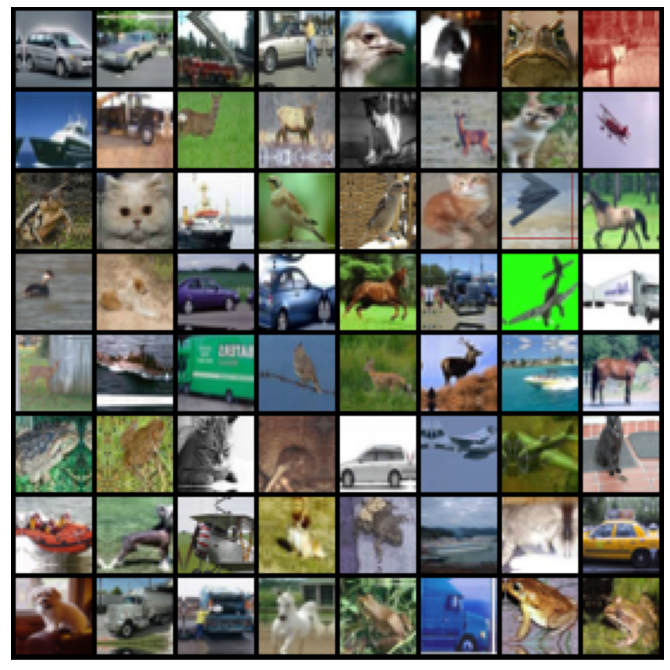

In [10]:
show_batch(train_dl)

정규화를 거쳤기 때문에 일부 이미지의 색상이 달라진 것처럼 보일 수 있다. 추론과정 중에도 정규화를 적용할 수 있다. 자세히 보면 이미지들에 적용된 증강 기법이 얼추 보일 것이다. (수평 뒤집기, 자르기, 회전 등)

## GPU 사용

GPU를 원활하게 사용하기 위해 사용 가능한 경우 몇 가지 도우미 함수(`get_default_device` 및 `to_device`)와 도우미 클래스 `DeviceDataLoader`를 정의하여 필요에 따라 모델 및 데이터를 GPU로 이동한다.

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

이 노트북을 실행하는 위치에 따라 기본 장치는 CPU(`torch.device('cpu')`) 또는 GPU(`torch.device('cuda')`)일 수 있다.

In [12]:
device = get_default_device()
device

device(type='cuda')

이제 데이터 배치를 GPU로 자동 전송하기 위해 `DeviceDataLoader`를 사용하여 훈련 및 검증 데이터 로더를 래핑할 수 있다(사용 가능한 경우에).

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## 잔차 블록 및 배치 정규화 모델

이번에 CNN 모델의 주요 변경 사항 중 하나는 하나 이상의 컨볼루션 레이어를 통해 입력을 전달하여 얻은 출력 기능 맵에 원래 입력을 다시 추가하는 블록을 추가하는 것이다.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

다음은 매우 간단한 잔차 블록이다.

In [14]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [15]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


이 작은 변화로 인해 모델의 성능이 크게 향상된다. 또한 각 컨볼루션 레이어 다음에 배치 정규화 레이어를 추가하여 이전 레이어의 출력을 정규화한다.

자세한 내용은 다음 블로그 게시물을 참조해라.

* 잔차 블록이 작동하는 이유 및 방법: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* 일괄 정규화 및 드롭아웃 설명: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

[이 블로그 시리즈](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/)에 설명된 대로 ResNet9 아키텍처를 사용한다.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## 모델 훈련

모델을 훈련시키기 전에 `fit` 함수를 개선해볼 것임:

* **Learning rate scheduling**: 고정 학습률을 사용하는 대신 학습률 스케줄러를 사용한다. 이 스케줄러는 모든 훈련 배치 후에 학습률을 변경한다.  훈련 중 학습률을 변경하기 위한 많은 전략이 있으며 우리가 사용할 전략은 **"One Cycle Learning Rate Policy"**라고 하며 낮은 학습률에서 시작하여 점차적으로 배치별로 증가시키는 방식이다. epoch의 약 30% 동안 높은 학습률로 배치한 다음 나머지 epoch에 대해 매우 낮은 값으로 점차 감소시킨다. 더 알아보기: https://sgugger.github.io/the-1cycle-policy.html

* **가중치 감소**: 손실 함수에 항을 추가하여 가중치가 너무 커지는 것을 방지하는 또 다른 정규화 기술인 가중치 감소도 사용한다. 더 알아보기: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **그라디언트 클리핑**: 레이어 가중치 및 출력 외에도 큰 그라디언트 값으로 인한 매개변수의 바람직하지 않은 변경을 방지하기 위해 그라디언트 값을 작은 범위로 제한하는 것도 도움이 된다. 이 간단하지만 효과적인 기술을 그라디언트 클리핑이라고 한다. 더 알아보기: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

이러한 변경 사항을 통합하기 위해 `fit_one_cycle` 함수를 정의해 보겠다. 또한 각 배치에 사용된 학습률을 기록한다.



In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.304723024368286, 'val_acc': 0.10000000894069672}]

이제 모델을 훈련할 준비가 되었다. SGD(확률적 경사 하강법) 대신 더 빠른 훈련을 위해 운동량 및 적응 학습률과 같은 기술을 사용하는 Adam 최적화 프로그램을 사용한다.

여기에 옵티마이저에 대해 자세히 서술되 있다. https://ruder.io/optimizing-gradient-descent/index.html

In [21]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5116, val_loss: 1.2002, val_acc: 0.5696
Epoch [1], last_lr: 0.00935, train_loss: 1.0938, val_loss: 1.3571, val_acc: 0.5703
Epoch [2], last_lr: 0.00972, train_loss: 0.8496, val_loss: 0.8483, val_acc: 0.7239
Epoch [3], last_lr: 0.00812, train_loss: 0.6358, val_loss: 0.7258, val_acc: 0.7565
Epoch [4], last_lr: 0.00556, train_loss: 0.5100, val_loss: 0.6407, val_acc: 0.7877
Epoch [5], last_lr: 0.00283, train_loss: 0.4052, val_loss: 0.3849, val_acc: 0.8690
Epoch [6], last_lr: 0.00077, train_loss: 0.2993, val_loss: 0.3210, val_acc: 0.8939
Epoch [7], last_lr: 0.00000, train_loss: 0.2256, val_loss: 0.2845, val_acc: 0.9058
CPU times: user 55.2 s, sys: 34.3 s, total: 1min 29s
Wall time: 1min 32s


In [23]:
train_time='4:24'

우리 모델은 **5분 이내에** 90% 이상의 정확도로 훈련되었다! 

시간이 지남에 따라 모델이 어떻게 개선되는지 연구하기 위해 검증 세트 정확도를 시각화해보자.

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

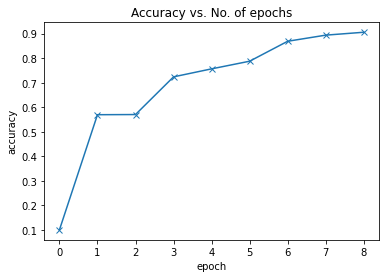

In [25]:
plot_accuracies(history)

또한 추세를 연구하기 위해 훈련 및 검증 손실을 플롯할 수 있습니다.

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

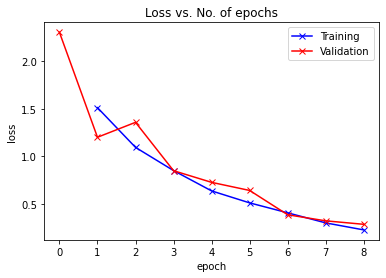

In [27]:
plot_losses(history)

우리 모델이 아직 훈련 데이터에 과적합되지 않는다는 추세에서 분명하다.

일괄 정규화, 데이터 증대 및 잔차 계층을 하나씩 제거하여 과적합에 미치는 영향을 연구해보아라.

마지막으로 모든 에포크에 걸쳐 배치별로 학습률이 시간이 지남에 따라 어떻게 변했는지 시각화해 보겠다.

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

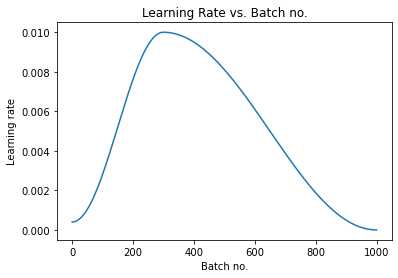

In [29]:
plot_lrs(history)

예상대로 학습률은 낮은 값에서 시작하여 반복의 30% 동안 최대값 `0.01`까지 점차 증가하다가 점차적으로 매우 작은 값으로 감소한다.

## 개별 이미지로 테스트

지금까지 모델의 전체 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 확인하는 것도 좋은 생각이다.

미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠다.

In [30]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


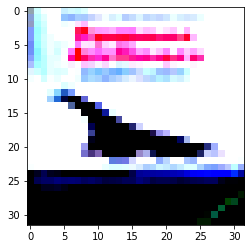

In [31]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


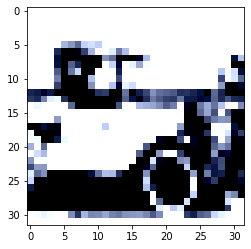

In [32]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


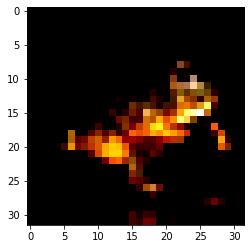

In [33]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

모델 성능이 저조한 위치를 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 초매개변수를 변경하여 모델을 개선하는 데 도움이 될 수 있다.

## 요약 및 추가 읽을거리

이제 최첨단 딥 러닝 모델을 처음부터 훈련할 준비가 되었다. 다음 지침에 따라 프로젝트를 직접 시도해 보세요:
https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project

아래에는 이번 노트북에서 모델 성능을 개선하고 교육 시간을 줄이기 위해 사용된 다양한 기술에 대한 요약임:

* **데이터 정규화**: 평균을 빼고 각 채널의 픽셀 표준 편차로 나누어 이미지 텐서를 정규화했다. 데이터를 정규화하면 한 채널의 픽셀 값이 손실 및 기울기에 불균형적으로 영향을 미치는 것을 방지할 수 있다.[더 알아보기](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **데이터 증대**: 훈련 데이터 세트에서 이미지를 로드하는 동안 무작위 변환을 적용했다. 특히, 각 이미지에 4픽셀을 채우고 32 x 32픽셀 크기의 임의 자르기를 수행한 다음 50% 확률로 이미지를 수평으로 뒤집는다.
[더 알아보기](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **잔차 연결**: CNN 모델의 주요 변경 사항 중 하나는 하나 이상의 컨볼루션 레이어를 통해 입력을 전달하여 얻은 출력 특성 맵에 원래 입력을 다시 추가하는 다시 입력 블록을 추가한 것이다. ResNet9 아키텍처[더 알아보기](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)를 사용했다.

* **배치 정규화**: 각 컨볼루션 레이어 뒤에 배치 정규화 레이어를 추가하여 이전 레이어의 출력을 정규화했다. 이것은 계층의 출력에 적용되고 평균과 표준 편차가 학습된 매개변수라는 점을 제외하면 데이터 정규화와 다소 유사하다. [더 알아보기](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **학습률 스케줄링**: 고정된 학습률을 사용하는 대신 학습률 스케줄러를 사용합니다. 이 스케줄러는 모든 교육 배치 후에 학습률을 변경한다. 훈련 중 학습률을 변경하기 위한 [많은 전략](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)이 있으며, 우리는 "One Cycle Learning Rate Policy"를 사용했다. [더 알아보기](https://sgugger.github.io/the-1cycle-policy.html)

* **가중치 감소**: 옵티마이저에 가중치 감소를 추가했지만 손실 함수에 추가 항을 추가하여 가중치가 너무 커지는 것을 방지하는 또 다른 정규화 기술이다. [더 알아보기](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **그라디언트 클리핑**: 또한 그라디언트 값을 작은 범위로 제한하여 훈련 중 큰 그라디언트 값으로 인한 모델 매개변수의 바람직하지 않은 변경을 방지하는 데 도움이 되는 그라디언트 클립핑을 추가했다. [더 알아보기](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam 옵티마이저**: SGD(stochastic gradient descent) 대신에 더 빠른 훈련을 위해 운동량 및 적응 학습률과 같은 기술을 사용하는 Adam 옵티마이저를 사용했다. 선택하고 실험할 다른 많은 최적화 도구가 있다. [더 알아보기](https://ruder.io/optimizing-gradient-descent/index.html)

코딩 연습으로 각 기술을 독립적으로 적용하고 각 기술이 수행 및 훈련 시간에 얼마나 영향을 미치는지 확인해야 한다. 다양한 실험을 시도하면서 올바른 아키텍처, 데이터 증강 및 정규화 기술을 선택하기 위한 직관력이 길러질 것이다.